In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk

In [2]:
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_csv("wiki_movie_plots_deduped.csv")


In [5]:
df.tail()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
3588,1943,I Walked with a Zombie,American,Jacques Tourneur,"Frances Dee, Tom Conway",horror,https://en.wikipedia.org/wiki/I_Walked_with_a_...,"Betsy Connell (Frances Dee), a Canadian nurse,..."
3589,1943,Immortal Sergeant,American,John M. Stahl,"Henry Fonda, Maureen O'Hara",war,https://en.wikipedia.org/wiki/Immortal_Sergeant,"In North Africa, experienced Sergeant Kelly (T..."
3590,1943,In Old Oklahoma,American,Albert S. Rogell,"John Wayne, Martha Scott, Dale Evans",western,https://en.wikipedia.org/wiki/In_Old_Oklahoma,Eastern school teacher Catherine Allen becomes...
3591,1943,The Iron Major,American,Ray Enright,"Pat O'Brien, Ruth Warrick",biographical,https://en.wikipedia.org/wiki/The_Iron_Major,"Florence Cavanaugh and a priest, Tim Donovan, ..."
3592,1943,Isle of Forgotten Sins,American,Edgar G. Ulmer,"Gale Sondergaard, John Carradine",adventure,https://en.wikipedia.org/wiki/Isle_of_Forgotte...,Somewhere on one of the English-speaking South...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3593 entries, 0 to 3592
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      3593 non-null   int64 
 1   Title             3593 non-null   object
 2   Origin/Ethnicity  3593 non-null   object
 3   Director          3593 non-null   object
 4   Cast              3547 non-null   object
 5   Genre             3593 non-null   object
 6   Wiki Page         3593 non-null   object
 7   Plot              3593 non-null   object
dtypes: int64(1), object(7)
memory usage: 224.7+ KB


In [7]:
df['Genre']=df['Genre'].replace('unknown',np.nan)
df=df.dropna(axis=0, subset=['Genre'])
print(df.tail())

      Release Year                   Title Origin/Ethnicity          Director  \
3588          1943  I Walked with a Zombie         American  Jacques Tourneur   
3589          1943       Immortal Sergeant         American     John M. Stahl   
3590          1943         In Old Oklahoma         American  Albert S. Rogell   
3591          1943          The Iron Major         American       Ray Enright   
3592          1943  Isle of Forgotten Sins         American    Edgar G. Ulmer   

                                      Cast         Genre  \
3588               Frances Dee, Tom Conway        horror   
3589           Henry Fonda, Maureen O'Hara           war   
3590  John Wayne, Martha Scott, Dale Evans       western   
3591             Pat O'Brien, Ruth Warrick  biographical   
3592      Gale Sondergaard, John Carradine     adventure   

                                              Wiki Page  \
3588  https://en.wikipedia.org/wiki/I_Walked_with_a_...   
3589    https://en.wikipedia.org/w

In [8]:
print(df.shape)
print(len(df))
a=df['Genre'].value_counts()[:20]
b=a.keys().tolist()
print(b)
df=df[df.Genre.isin(b)]
df=df.reset_index(drop=True)

(3531, 8)
3531
['drama', 'comedy', 'western', 'mystery', 'musical', 'adventure', 'romantic comedy', 'crime', 'musical comedy', 'comedy, drama', 'romance', 'drama, crime', 'comedy, musical', 'war', 'comedy drama', 'horror', 'drama, adventure', 'crime drama', 'comedy short', 'comedy, romance']


<Axes: xlabel='Count', ylabel='Genre'>

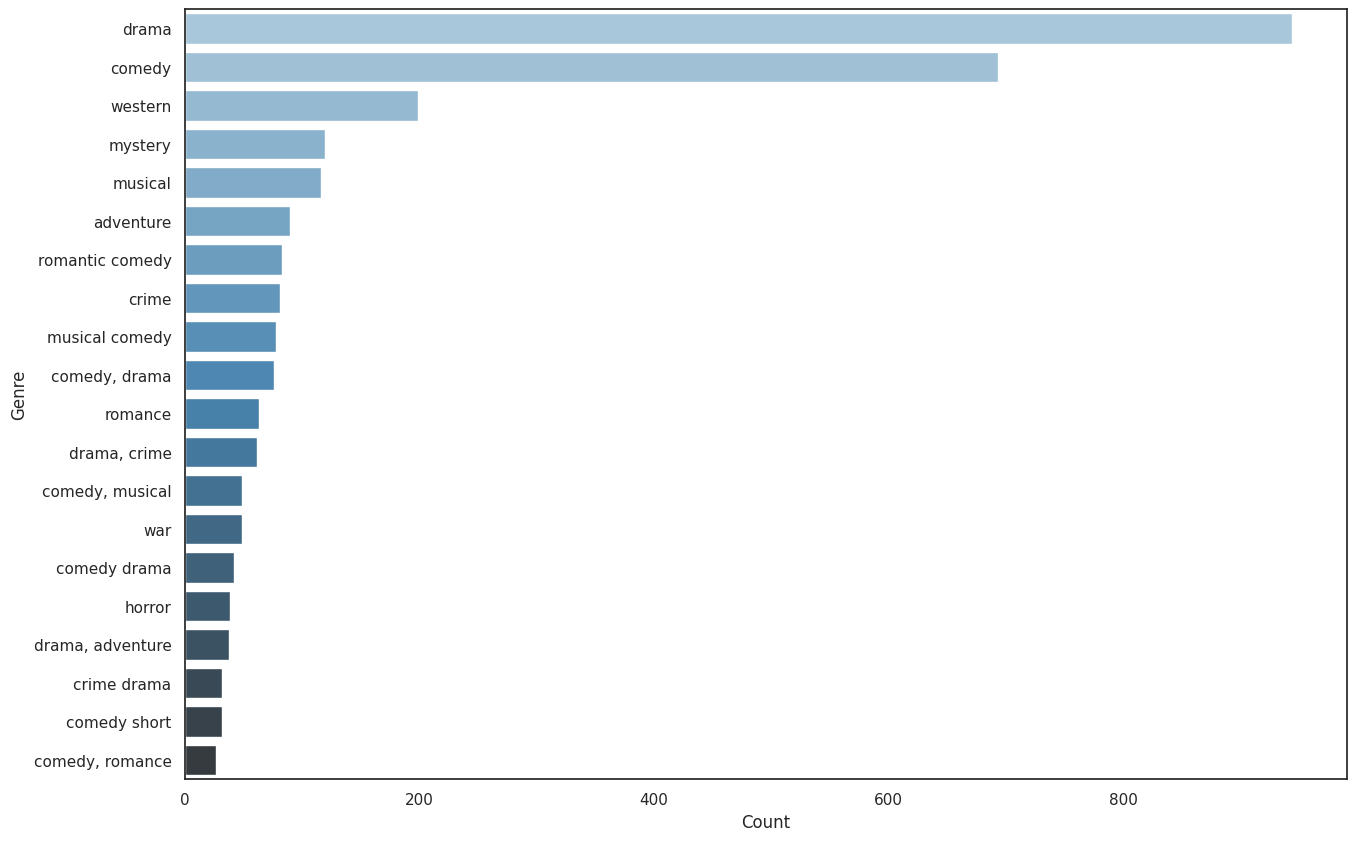

In [9]:
sns.set(style="white")
genre_to_count=pd.DataFrame({'Genre':a.index, 'Count':a.values})
plt.figure(figsize=(15,10))
sns.barplot(y="Genre", x="Count", data=genre_to_count,palette="Blues_d")


In [10]:
def plotToWords(raw_plot):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_plot)
    lower_case = letters_only.lower()
    words = lower_case.split()
    stops = set(stopwords.words("english"))
    meaningful_words = [w for w in words if not w in stops]
    return (" ".join(meaningful_words))


In [11]:
def preprocess(dataframe):
    clean_train_reviews = []
    for i in range(0,len(dataframe)):
        clean_train_reviews.append(plotToWords(dataframe.iloc[i]['Plot']))
    dataframe['Plot']=clean_train_reviews
    return dataframe

In [12]:
df=preprocess(df)
print(df["Plot"][:10])

0    film opens two bandits breaking railroad teleg...
1    film family move suburbs hoping quiet life thi...
2    heading baseball game nearby ballpark sports f...
3    plot black woman going dentist toothache given...
4    beautiful summer day father mother take daught...
5    thug accosts girl leaves workplace man rescues...
6    young couple decides elope caught midst romant...
7    white girl florence lawrence rejects proposal ...
8    prints first american film adaptation christma...
9    film opens town mexican border poker game goin...
Name: Plot, dtype: object


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), max_features=4000)
features = tfidf.fit_transform(df.Plot).toarray()
labels = df.Genre
features.shape

(2913, 4000)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Plot'], df['Genre'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)


In [15]:
print(clf.predict(count_vect.transform(["In an interview with CBC Radio, UniversitÃ© de MontrÃ©al History Professor Dominique St. Arnaud tells Diane about her new book, Variations on the Idea of Happiness, which discusses her thesis that modern society's fixation on self-indulgence is indicative of its decline, predicting a collapse in the ""American Empire,"" of which Quebec is on the periphery. Several of Dominique and Diane's friends, mostly intellectual history professors at the university, prepare for a dinner later in the day, with the men at work in the kitchen while the women work out at the gym. As the dinner draws nearer, the men and women mainly talk about their sex lives, with the men being open about their adulteries, including RÃ©my, who is married to Louise. Most of the women in the circle of friends have had sex with RÃ©my, though he is not attractive, but they conceal this from Louise to spare her feelings. Louise has been to an orgy with RÃ©my, but believes he is generally faithful to her in Montreal. The friends are also accepting of their homosexual friend Claude, who speaks about pursuing men reckless of fear of STDs, while secretly being fearful of having one. During the dinner party, the friends listen to Dominique's theories about the decline of society, with Louise expressing skepticism. To retaliate against Louise, Dominique reveals she has had sex with RÃ©my and their friend Pierre, causing her to have an emotional meltdown. By morning, relationships have gone back to normal."])))

['drama']


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

<Axes: xlabel='model_name', ylabel='accuracy'>

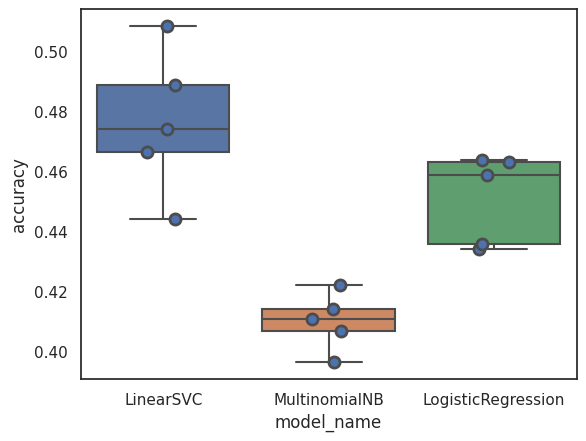

In [17]:
models = [
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)

In [18]:
plt.show()

In [19]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC             0.476495
LogisticRegression    0.451088
MultinomialNB         0.409888
Name: accuracy, dtype: float64